## Estimating causal effect of moisture on GPP/NEE

In this notebook, we use FluxNet data to test the GPP/NEE-moisture sensitivity. 

We focus on the sites in US, AU, Mongolian and EU. 

We use GPP/NEE as Y, and first use precipitation as X, and then soil moisture as X. 

Is the confounder variable temporal or spatial? Two assumptions are both testable. 

[//]: # "the confounder could be spatial factor, such as site, local climatology, or PFTs. "

Reference: 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3479688/

https://arxiv.org/pdf/2005.08639.pdf


In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr

from scipy.spatial.distance import cdist
from scipy.linalg import cholesky
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 200
import seaborn as sns

### Load data

Fluxnet annul data is used. See this [link](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/) for more information.

Focus on CSH, OSH, WSA, SAV, GRA PFTs.

In [25]:
# this should be read only, use Jianing's data
path_ro = '/burg/glab/users/jf3423/data/FLUXNET_Annual'
site  = os.listdir(path_ro)
meta_file = list(filter(lambda f: f.endswith('.csv'), site))[0]
site.remove(meta_file)

meta_file = pd.read_csv(path_ro+'/FLUXNET_YY_metadata.csv')  
meta_file['length'] = meta_file['end_year'] - meta_file['start_year'] + 1 
meta_file = meta_file.loc[meta_file.length >= 10]
print('Number of sites with over 10 yrs data in metadata: ', len(meta_file))
meta_file.head(3)
meta_data = meta_file.copy()

Number of sites with over 10 yrs data in metadata:  69


In [3]:
PFT = ['CSH', 'OSH', 'WSA', 'SAV', 'GRA']
CSH = meta_file.loc[meta_file.IGBP == 'CSH'].SITE_ID.values
OSH = meta_file.loc[meta_file.IGBP == 'OSH'].SITE_ID.values
WSA = meta_file.loc[meta_file.IGBP == 'WSA'].SITE_ID.values
SAV = meta_file.loc[meta_file.IGBP == 'SAV'].SITE_ID.values
GRA = meta_file.loc[meta_file.IGBP == 'GRA'].SITE_ID.values
print('Number of sites in CSH:', len(CSH), ' OSH:', len(OSH), ' WSA:', len(WSA), ' SAV:', len(SAV), ' GRA:', len(GRA))
# some sites' data is not available 
GRA = ['AT-Neu', 'CH-Fru', 'DE-Gri', 'GL-ZaH', 'US-Var', 'US-Wkg']

Number of sites in CSH: 1  OSH: 2  WSA: 3  SAV: 0  GRA: 8


In [4]:
# Use US-Ha1 and US-Var to test 
## XX stands for percentiles, CUT stands for Constant Ustar Threshold and VUT stands for Variable Ustar Threshold 

sitename = 'US-Ha1'
GPP_flag = -9999
file = os.listdir(path_ro+'/'+sitename)
print('number of files in this directory is: ', len(file))
filename = file[0]
data = pd.read_csv(path_ro+'/'+sitename+'/'+filename)

# for i in data.columns:
#     print(i)

number of files in this directory is:  1


data length in years from this site:  22


Text(0, 0.5, 'carbon flux')

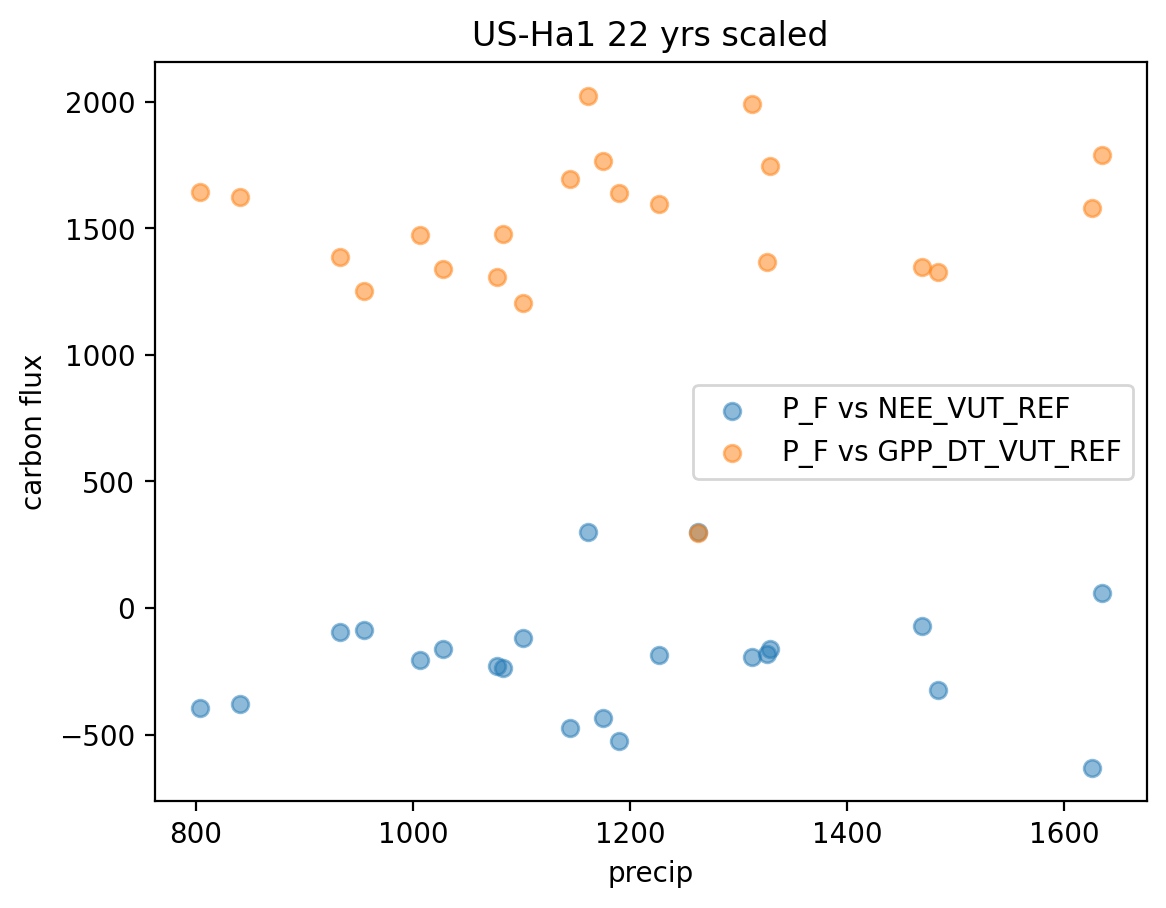

In [5]:
data = data[['GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'NEE_VUT_REF', 'P_F',]] 

# there is no soil water content in the data 'SWC_F_MDS_#'

# data = (data - data.mean())/data.std()
data = data.loc[data.GPP_NT_VUT_REF != GPP_flag]
print('data length in years from this site: ', len(data))

### plt.scatter(data.P_F, data.NEE_CUT_REF, label = 'P_F NEE CUT REF', alpha = 0.5)
plt.scatter(data.P_F, data.NEE_VUT_REF, label = 'P_F vs NEE_VUT_REF', alpha = 0.5)
plt.scatter(data.P_F, data.GPP_DT_VUT_REF, label = 'P_F vs GPP_DT_VUT_REF', alpha = 0.5)

### plt.scatter(data.P_ERA, data.NEE_CUT_REF, label = 'P_ERA NEE CUT REF', alpha = 0.5)
### plt.scatter(data.P_ERA, data.NEE_VUT_REF, label = 'P_ERA NEE VUT REF', alpha = 0.5)
plt.legend()
plt.title(sitename+' '+str(len(data))+' yrs scaled')
plt.xlabel('precip')
plt.ylabel('carbon flux')


### Merge / append all the sites data together

Different sites have different data length/sample number. Select the sites with >=10 years of data.

In [26]:
meta_file

,SITE_ID,IGBP,LAT,LONG,ELEV,MAT,MAP,start_year,end_year,length
2,AT-Neu,GRA,47.11667,11.31750,970.0,6.50,852.0,2002,2012,11
14,AU-How,WSA,-12.49430,131.15230,-9999.0,-9999.00,-9999.0,2001,2014,14
21,AU-Tum,EBF,-35.65660,148.15170,1200.0,-9999.00,-9999.0,2001,2014,14
26,BE-Bra,MF,51.30761,4.51984,16.0,9.80,750.0,1996,2014,19
27,BE-Lon,CRO,50.55162,4.74623,167.0,10.00,800.0,2004,2014,11
...,...,...,...,...,...,...,...,...,...,...
188,US-UMB,DBF,45.55980,-84.71380,234.0,5.83,803.0,2000,2014,15
190,US-Var,GRA,38.41330,-120.95070,129.0,15.80,559.0,2000,2014,15
191,US-WCr,DBF,45.80590,-90.07990,520.0,4.02,787.0,1999,2014,16
204,US-Wkg,GRA,31.73650,-109.94190,1531.0,15.64,407.0,2004,2014,11


In [7]:
min_yrs = 10
GPP_flag = -9999
varname = ['P_F', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'NEE_VUT_REF']
path_ro = '/burg/glab/users/jf3423/data/FLUXNET_Annual'

site  = os.listdir(path_ro)
meta_file = list(filter(lambda f: f.endswith('.csv'), site))[0]
site.remove(meta_file)
print('Number of sites under Jianing directory: ', len(site))

def merge_all_sites(site, path_ro, min_yrs, varname, GPP_flag):
    # output data_allsites: the dataframe to contain all sites' info
    # input site: a list containing all sites' names
    # input min_yrs: minimum sample number (yr) required for each site to be include
    # input GPP_flag: use to filter missing/weird data
    
    # global data_allsites
    data_allsites = pd.DataFrame(data = None, index = None, columns = varname)
    data_allsites.index.name = 'site'
    
    for sitename in site:
        # print('processing site: ', sitename)
        file = os.listdir(path_ro+'/'+sitename)
        if len(file) > 1:
            print('number of files in this directory is: ', len(file))
        filename = file[0]
        data = pd.read_csv(path_ro+'/'+sitename+'/'+filename)
        data = data[varname]
        data = data.loc[data.GPP_NT_VUT_REF != GPP_flag]
        # data = (data - data.mean())/data.std()
        # print('data length in years from this site: ', len(data))
        
        if len(data) >= min_yrs:
            data['site'] = sitename
            data = data.set_index('site')
            # data_allsites = data_allsites.append(data, ignore_index = False) 
            data_allsites = pd.concat([data_allsites, data])
            
    return data_allsites
        
data_allsites = merge_all_sites(site, path_ro, min_yrs, varname, GPP_flag)
site_new = data_allsites.index.unique()

data_allsites

Number of sites under Jianing directory:  193


,P_F,GPP_NT_VUT_REF,GPP_DT_VUT_REF,NEE_VUT_REF
site,,,,
DE-Geb,423.278,1188.070,1260.300,-198.7360
DE-Geb,674.086,896.108,927.332,-36.1059
DE-Geb,388.100,990.353,1024.750,-301.6900
DE-Geb,506.600,1289.000,1312.030,-233.3910
DE-Geb,521.900,1272.410,1268.040,-90.1472
...,...,...,...,...
CH-Fru,1771.200,1981.580,1755.200,-234.7880
CH-Fru,696.180,2312.110,1998.360,-318.9610
CH-Fru,1159.938,1995.700,2036.320,-205.0280


### Spatial confounder assumption
#### Causal effect estimation

Use site as the the hidden confounder H.

Recall the ground-truth causal effect formula for $Y$ if using OLS to estimate $Y$ from $X$:

$$
\begin{align}
f_{AVE}(X \rightarrow Y)(x) = \frac{1}{n} \sum_{i=1}^{n} (1 \ \  x) \hat{\beta}_{OLS}(X^m_i,Y^m_i) \\
\end{align}
$$



The estimated causal coefficients: a = 1322.42, b = 0.06


Text(0.5, 1.0, 'OLS fit GPP_DT_VUT_REF vs P_F')

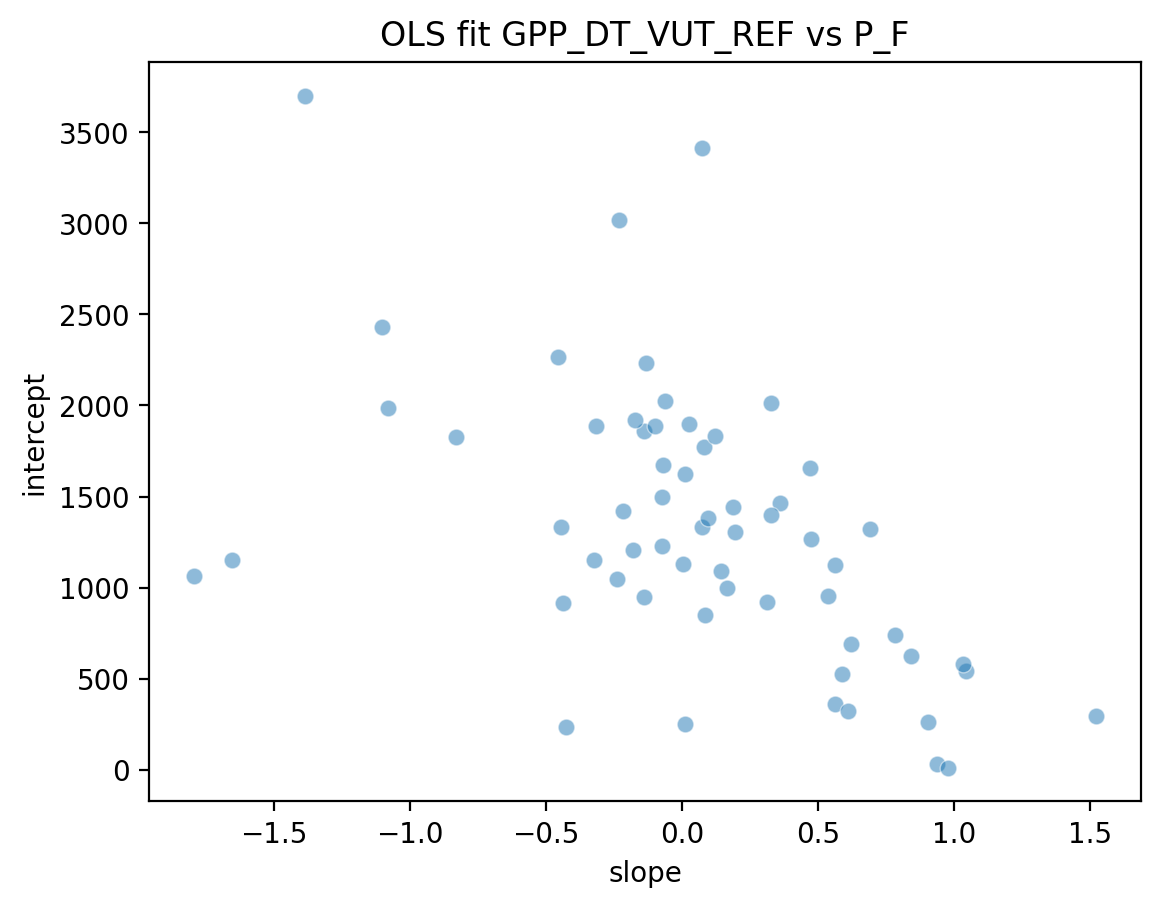

In [8]:
# estimated coefficients when we decorrelate spatial dependency (ie. compute coefficient at each location)
xname = 'P_F'
# yname = 'NEE_VUT_REF'
yname = 'GPP_DT_VUT_REF'

# this is to compute the linear regression for each site
def bhat(data_allsites, xname, yname):
    # N: site number
    results = list()
    
    site_new = data_allsites.index.unique()
    N = len(site_new) # number of sites
    
    for s, sname in enumerate(site_new):
        Xs = data_allsites.loc[sname][xname].values
        Ys = data_allsites.loc[sname][yname].values
        model = LinearRegression().fit(Xs.reshape(-1, 1), Ys.reshape(-1, 1))
        results.append([model.intercept_, model.coef_[0]])
        
    return np.array(results)
    
bhat_data = bhat(data_allsites, xname, yname)
b_causal_data = np.mean(bhat_data, axis=0)
print(f"The estimated causal coefficients: a = {b_causal_data[0].item():.2f}, b = {b_causal_data[1].item():.2f}")

linedata = pd.DataFrame({'intercept': bhat_data[:, 0, 0], 'slope': bhat_data[:, 1, 0]})
sns.scatterplot(data=linedata, x = 'slope', y = 'intercept', alpha=.5, linewidth=.5,)
plt.title('OLS fit '+yname+' vs '+xname)

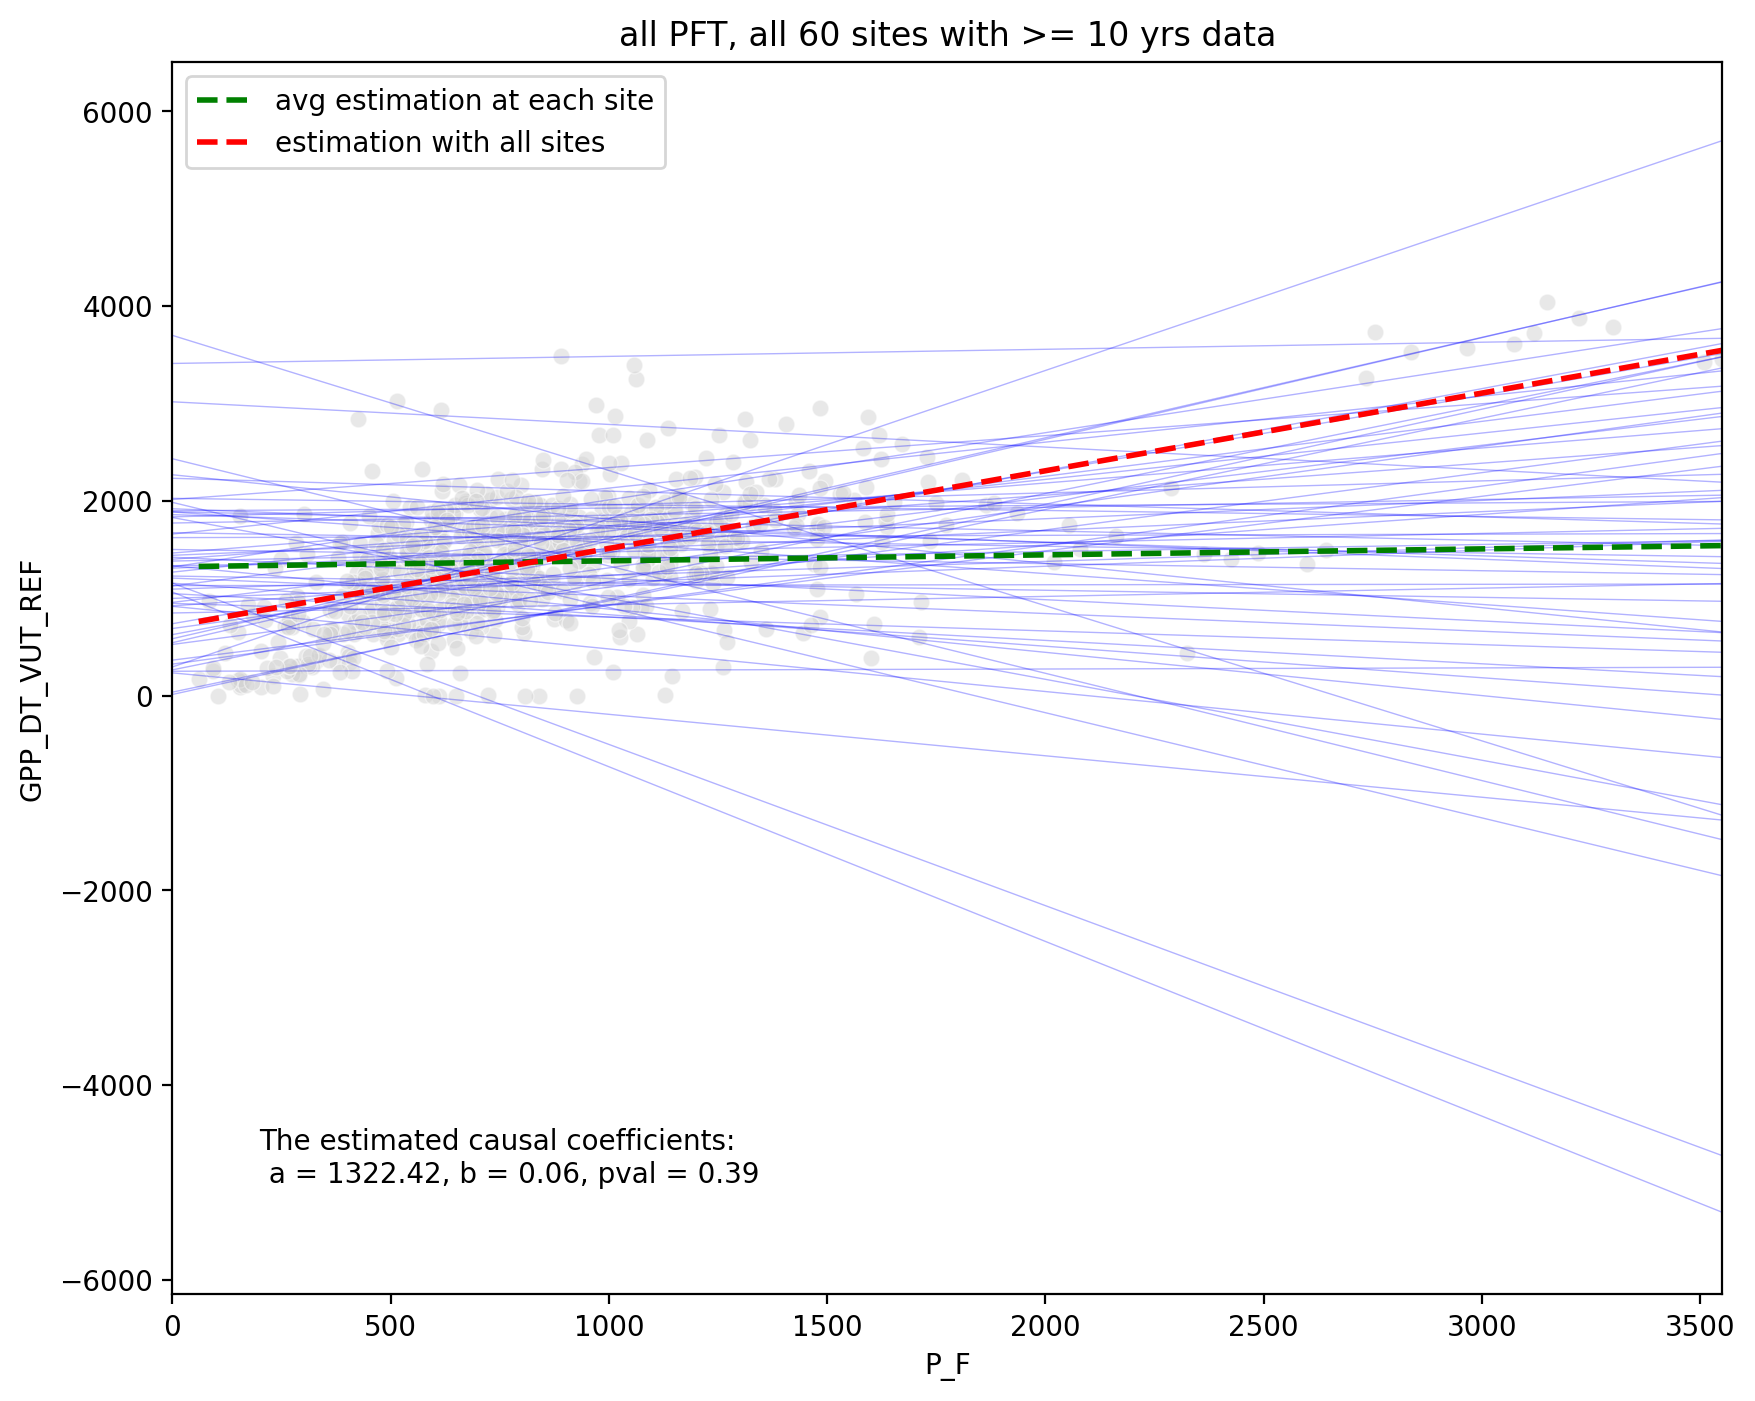

In [9]:
## red: linear regression using all data
## thin blue: linear regressions within each site/location
## green: estimate of the avg causal effect

X = data_allsites[xname].values.ravel()
Y = data_allsites[yname].values.ravel()
model = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
a = model.intercept_
b = model.coef_[0]
x_increments = np.arange(0,3800,100)
# x_increments = np.arange(-2,2,100)

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=data_allsites[list([xname,yname])], x=xname, y=yname, alpha=.5, color='lightgrey', ax=ax)

for i in range(bhat_data.shape[0]):
    bhat_d = bhat_data[i]
    sns.lineplot(x = x_increments, y = bhat_d[0] + x_increments * bhat_d[1], color='blue', linewidth=0.5, alpha=0.3, ax=ax)

sns.lineplot(x = X, y = b_causal_data[0] + b_causal_data[1]*X, color='green', linewidth=2, linestyle='--', label='avg estimation at each site', ax=ax)
sns.lineplot(x = X, y = a + b*X, color='red', linewidth=2, linestyle='--', label='estimation with all sites', ax=ax)

ax.set_xlabel(xname)
ax.set_xlim([0, X.max()])
ax.set_ylabel(yname)
ax.set_title('all PFT, all '+str(len(data_allsites.index.unique()))+ ' sites with >= 10 yrs data')
ax.annotate("The estimated causal coefficients: \n a = {:.2f}, b = {:.2f}, pval = 0.39".format(b_causal_data[0].item(), b_causal_data[1].item()), xy = (200, -5000))
plt.show()

### Significance test

$\hat{T}$ is the test statistic.

Let $M := m!$ and let $\sigma_1, ..., \sigma_M$ be all permutations of the elements in $\{1,2,...,m\}$.

Let $B \in N$ and let $k_1, ..., k_B$ be independent, uniform draws from $\{1, ..., M\}$.

$\sigma(x, y)$ denotes the permuted array with entries $(\sigma(x, y))^t_s = (x^t_s, y^{\sigma(t)}_s)$.

The p-value for significance test is:
$$
\begin{align}
    p_{\hat{T}}(x, y) := \frac{1+|b\in \{1, ..., B\}: \hat{T}(\sigma_{k_b})(x,y)\geq \hat{T}(x,y)|}{1+B}\\
\end{align}
$$

Null hypothesis is:
$H_0$ : $(X, Y)$ come from an LSCM with a function $f$ that is constant w.r.t. $X_t$, which formalizes the assumption of “no causal effect of $X$ on $Y$” within the LSCM framework.

https://github.com/runesen/spatio_temporal_causality/blob/master/figure_scripts/regional_effects.R

In [10]:
import random
from itertools import product
from sklearn.utils import resample
# random.sample(range(n), n)

df = data_allsites.copy()


In [33]:
# this is to compute the linear regression for each site
def bhat(data_allsites, xname, yname, b):
    from sklearn.utils import resample
    # N: site number
    results = list()
    
    sites = data_allsites.index.unique()
    N = len(sites) # number of sites
    
    for s, sname in enumerate(sites):
        Xs = data_allsites.loc[sname][xname].values
        Ys = data_allsites.loc[sname][yname].values
        # if scale
        # Xs = (Xs - np.mean(Xs))/np.std(Xs)
        # Ys = (Ys - np.mean(Ys))/np.std(Ys)
        if b == 0:  # actual data
            zz = np.arange(len(Xs))
        else:  # resampled data
            zz = resample(np.arange(len(Xs)), replace=True)
        # Xs = Xs[zz]
        Ys = Ys[zz]
        
        model = LinearRegression().fit(Xs.reshape(-1, 1), Ys.reshape(-1, 1))
        results.append([model.intercept_, model.coef_[0]])
        
    bhat_data = np.array(results)
    
    return bhat_data[:, 1, 0]
    
# Bootstrapping
ns = df.index.nunique()
B = 999
test_stats_boot = []
for b in range(B + 1):
    ts = bhat(df, xname, yname, b)
    if len(ts) != ns:
        ts = np.full(ns, np.nan)
    test_stats_boot.append(ts)

test_stats_boot_df = pd.DataFrame(test_stats_boot, columns=[f'ts_{i}' for i in range(1, ns + 1)])
# print(test_stats_boot_df)

# Function to calculate p-value
def pvfun(t, na_rm=False):
    t_data = t.loc[0]
    t_boot = t.loc[1:]
    b_non_na = np.sum(~np.isnan(t_boot))
    min_p_value = min(1, 2 * min((1 + np.sum(t_boot <= t_data)) / (1 + b_non_na), (1 + np.sum(t_boot >= t_data)) / (1 + b_non_na)))
    return min_p_value

# Apply the pvfun function to compute p-values for each province
pv = test_stats_boot_df.apply(pvfun, axis=0).reset_index()
pv.columns = ['site', 'pval']
pv['site'] = df.index.unique()
pv['Pmean'] = df.reset_index().groupby('site').mean()[xname].values
pv['length'] = df.reset_index().groupby('site').count()[xname].values
pv['coef'] = test_stats_boot_df.mean(axis=0).values
PFT = [meta_file.loc[meta_file.SITE_ID == i]['IGBP'].values[0] for i in pv.site]
pv['PFT'] = PFT
pv.mean()

/tmp/ipykernel_2045694/159472860.py:60: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pv.mean()


pval        0.389500
Pmean     863.937251
length     13.483333
coef       -0.001959
dtype: float64

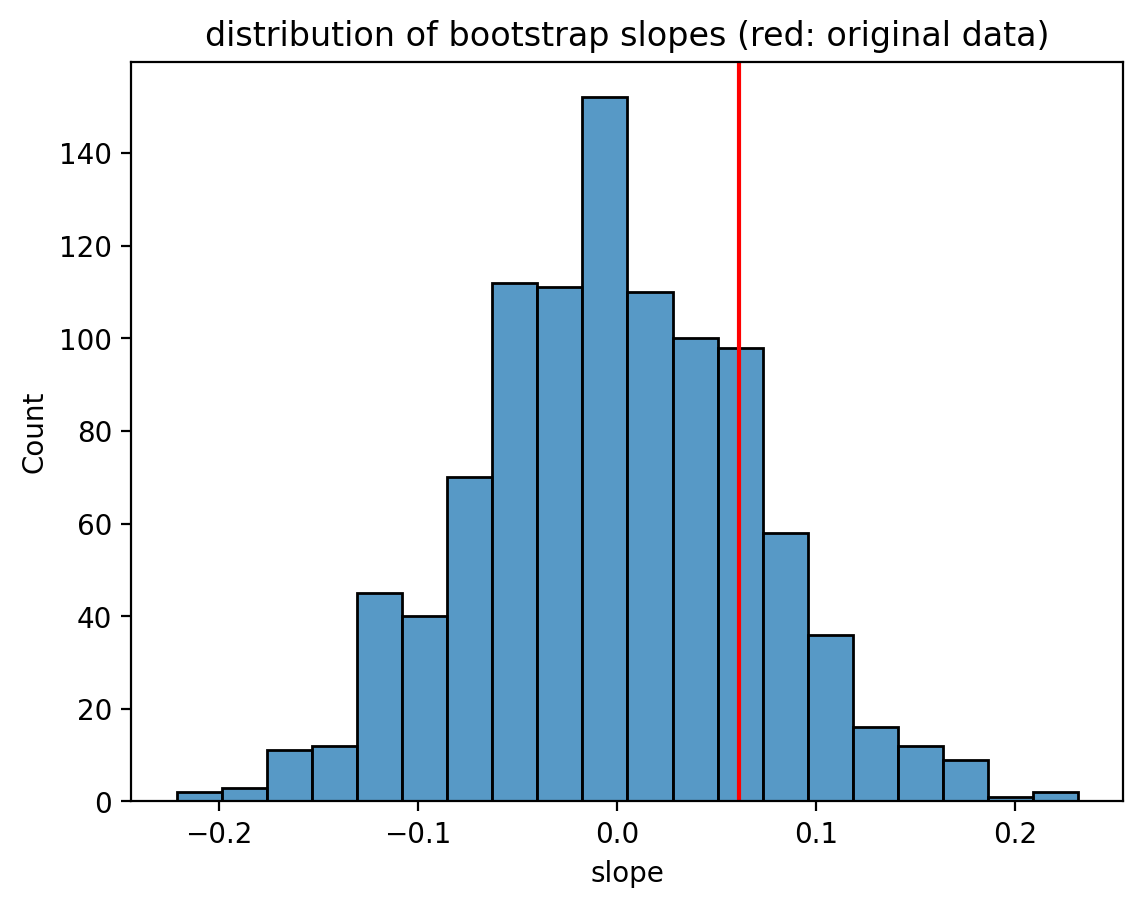

In [34]:
sns.histplot(test_stats_boot_df.mean(axis = 1), bins=20)
plt.axvline(x = test_stats_boot_df.loc[0].mean(), color='red')
plt.xlabel('slope')
plt.title('distribution of bootstrap slopes (red: original data)')
plt.show()

In [36]:
pv.sort_values('pval')

,site,pval,Pmean,length,coef,PFT
17,US-Me2,0.010,943.067364,11,0.003640,ENF
23,US-Wkg,0.016,529.065500,14,-0.021124,GRA
3,US-Ton,0.016,766.336364,11,0.001181,WSA
36,BE-Vie,0.018,877.895214,14,0.004473,MF
21,US-SRM,0.020,595.005200,10,-0.003737,WSA
15,US-ARM,0.028,1291.897182,11,-0.000085,CRO
10,US-Var,0.042,1107.760615,13,-0.002166,GRA
46,IT-Noe,0.044,486.042385,13,0.012586,CSH
34,IT-Lav,0.054,902.473933,15,0.001579,ENF
9,DE-Hai,0.064,1114.786500,12,-0.004990,DBF


<AxesSubplot:xlabel='Pmean', ylabel='coef'>

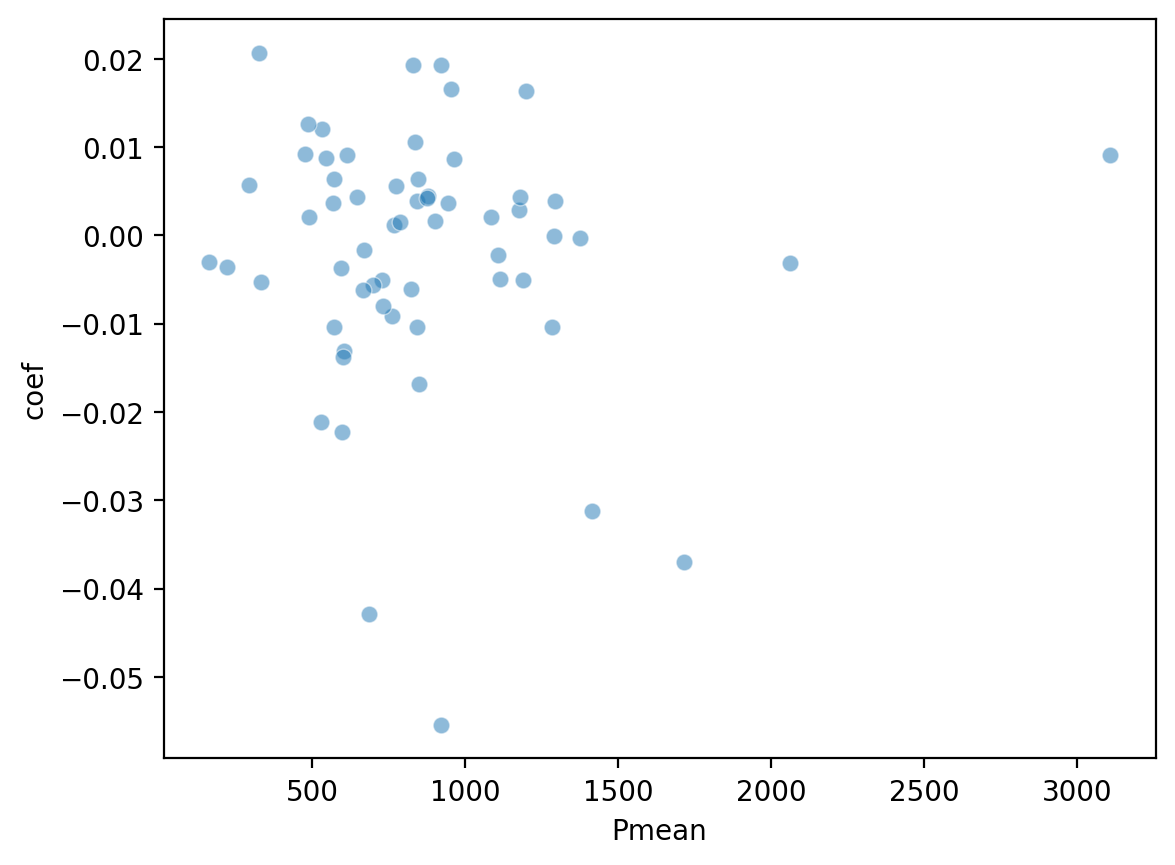

In [37]:
sns.scatterplot(data=pv, x = 'Pmean', y = 'coef', alpha=.5, linewidth=.5,)


### Why pval is ~0.4?

Each year the sample number is too few... OLS does not fit very well so the slope can easily be larger/small than the original data's when resampling.
Usually for 10 samples, the slope needs to be at the magnitude of 1 to pass the significance test.

In [38]:
# test_stats_boot_df.mean(axis=1)
# test_stats_boot_df.mean(axis=0)

test_stats_boot_df.rank().loc[0]

ts_1     249.0
ts_2     591.0
ts_3     909.0
ts_4     993.0
ts_5     583.0
ts_6     368.0
ts_7     201.0
ts_8     259.0
ts_9     106.0
ts_10    969.0
ts_11    980.0
ts_12    960.0
ts_13    793.0
ts_14    389.0
ts_15    131.0
ts_16    987.0
ts_17    913.0
ts_18    996.0
ts_19    401.0
ts_20    344.0
ts_21    657.0
ts_22    991.0
ts_23    841.0
ts_24    993.0
ts_25    936.0
ts_26    624.0
ts_27     45.0
ts_28    491.0
ts_29     69.0
ts_30    155.0
ts_31    648.0
ts_32    939.0
ts_33     55.0
ts_34    249.0
ts_35    974.0
ts_36    864.0
ts_37      9.0
ts_38     48.0
ts_39    137.0
ts_40     75.0
ts_41    265.0
ts_42    902.0
ts_43     70.0
ts_44    617.0
ts_45    141.0
ts_46    871.0
ts_47    979.0
ts_48    893.0
ts_49    578.0
ts_50    507.0
ts_51    764.0
ts_52    517.0
ts_53    880.0
ts_54    860.0
ts_55    423.0
ts_56    449.0
ts_57    928.0
ts_58    547.0
ts_59    259.0
ts_60    247.0
Name: 0, dtype: float64

### Temporal confounder assumption

Use ENSO index, such as Nino3.4 as the hidden confounder H. Or using ONI index: El Nino phase, La Nina phase, neutral phase.

The temporal range does not overlap well...

### Ecological confounder assumption
Use PFT as the hidden confounder H.

The site number with >=10 yrs data is 60. The GRA site number is 6 and the result is similar to that using all sites. The other sites' numbers belonging to CSH, OSH, WSA, and SAV are all <=3. Cannot go further in this direction.